In [1]:
import sklearn

import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

* 심층 신경망을 훈련할때 마주하는 문제
 - 심층 신경망의 아래쪽으로 갈수록 그레이디언트가 점점 더 작아지거나 커지는 그레이디언트 또는 그레디언트 폭주 문제
 - 대규모 신경망을 위한 훈련 데이터가 충분하지 않거나 레이블을 만드는 작업에 비용이 너무 많이 든다.
 - 훈련이 극단적으로 느려진다.
 - 수백만 개의 파라미터를 가진 모델은 훈랸 세트에 과대적합될 위험이 매우 크다.(특히 훈련 샘플이 충분하지 않거나 잡음이 많은 경우)

# 11.1 그레이디언트 소실과 폭주 문제 

* 역전파 알고리즘은 출력층에서 입력층으로 오차 그레이디언트를 전파하면서 진행된다. 알고리즘이 신경망의 모든 파라미터에 대한 오차 함수의 그레이디언트를 계산하면 경사 하강법 단계에서 이 그레이디언트를 사용하여 각 파라미터를 수정한다.
* 깊은 심층신경망에서는 역전파 알고리즘이 입력층으로 전달됨에 따라 그래디언트가 점점 작아져 결국 가중치 매개변수가 업데이트 되지 않는 경우가 발생하게 된다. 이러한 문제를 그래디언트 소실(vanishing gradient)라고 한다.
<img src = 'images/11_images/vanishing.png'>

* 그래디언트 소실과는 반대로 역전파에서 그래디언트가 점점 커져 입력층으로 갈수록 가중치 매개변수가 기하급수적으로 커지게 되는 경우가 있는데 이를 그래디언트 폭주(exploding gradient)라고 하며, 이 경우에는 발산(diverse)하게되어 학습이 제대로 이루어지지 않는다.

* 문제들의 원인은 그 당시에 많이 사용되는 로지스틱 시그모이드 활성화 함수와 그 당시 가장 인기있었던 가중치 초기화 방법의 조합이었다.
 - 이 활성화 함수와 초기화 방식을 사용했을 때 각 층에서 출력의 분산이 입력의 분산보다 더 크다는 것이 밝혀졌다.
 - 신경망의 위쪽으로 갈수록 층을 지날 때마다 분산이 계속 커져 가장 높은 층에서는 활성화 함수가 0이나 1로 수렴한다.
 - 로지스틱 함수를 보면 입력이 커지면 0이나 1로 수렴해서 기울기가 0에 매우 가까워지는 것을 알 수 있다. 그래서 역전파가 될 때 사실상 신경망으로 전파할 그레이디언트가 거의 없고, 조금 있는 그레이디언트는 최상위층에서부터 역전파가 진행되면서 점차 약해져서 실제로 아래쪽 층에는 아무것도 도달하지 않게 된다.

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

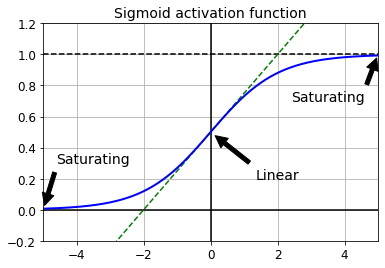

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

## 11.1.1 글로럿과 He 초기화

* 예측과 역전파할때 양방향 신호가 적절하게 흘러야 한다. 글로럿과 벤지오는 적잘한 신호가 흐르기 위해서는 각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야 한다고 주장했다. 그리고 역방향에서 층을 통과하기 전과 후의 그레이디언트 분산이 동일해야한다.
* 층의 입력(Fan-in)과 출력 연결 개수(Fan-out)가 같지 않다면 이 두 가지를 보장할 수 없다.
* 하지만 글로럿과 벤지오는 실전에서 매우 잘 작동한다고 입증된 대안을 제안
* 각 층의 연결 가중치를 밑의 방식대로 무작위로 초기화

* 글로럿 초기화(Glorot Initialization) 또는 세이비어 초기화(Xavier Initialization)
  - $ fan_{ang} = fan_{in} + fan_{out}/ 2 $
  - 평균이 0이고 분산이 $\sigma^2 = \frac{1}{fan_{avg}}$ 인 정규 분포 또는 $r = \sqrt{\frac{3}{fan_{{avg}}}}$ 일 때 -r과 +r 사이의 균등분포
  
* 르쿤 초기화(LuCun Initialization)
  - 평균이 0이고 분산이 $\sigma^2 = \frac{1}{fan_{in}}$ 인 정규 분포 또는 $r = \sqrt{\frac{3}{fan_{{in}}}}$ 일 때 -r과 +r 사이의 균등분포
  * He 초기화(He Initialization)
  - ReLU 활성화 함수에 대한 초기호 전략

|초기화 전략 | 활성화 함수 | $\sigma^2$ |
|-----------|-------------|--------------|
| 글로럿 | 활성화 함수 없음, 하이퍼볼릭 탄젠트, 로지스틱, 소프트맥스 | $\frac{1}{fan_{avg}}$|
|He | ReLU 함수와 그 변종들 | $\frac{2}{fan_{in}}$|
|로쿤 | SELU들 | $\frac{1}{fan_{in}}$|


In [4]:
#케라스는 기본적으로 균등분포의 글로럿 초기화 사용
#kernel_initializer = "he_uniform" / kernel_initializer = "he_normal"로 바꾸어 He 초기호 사용
keras.layers.Dense(10, activation="relu", kernel_initializer = "he_normal")

In [5]:
#fan_in 대신 fan_out 기반의 균등분포 He 초기화
he_avg_init = keras.initializers.VarianceScaling(scale = 2., mode = 'fan_avg', distribution = 'uniform')
keras.layers.Dense(10, activation = "sigmoid", kernel_initializer = he_avg_init)

## 11.1.2 수렴하지 않는 활성화 함수

* 대부분 생물학적 뉴런의 방식과 비슷한 시그모이드 활성화 함수가 최선의 선택일 것이라고 생각했었지만 다른 활성화 함수가 심층 신경망에서 훨씬 더 잘 작동한다는 사실이 밝혀졌다.
* ReLU 함수는 특정 양수값에 수렴하지 않고 계산이 빠르다는 장점이 있다. 하지만 훈련하는 동안 일부 뉴런이 0이외의 값을 출력하지 않는 죽은 ReLU(Dying ReLU) 문제가 있다. 뉴런의 가중치가 바뀌어 훈련 세트에 있는 모든 샘플에 대해 입력의 가중치 합이 음수가 되며 뉴런이 죽게되어 경사 하강법이 더 작동하지 않게된다.
* 이 문제를 해결하기 위해 LeakyReLU같은 함수의 변종을 사용
* $LeakyReLU_a$(z) = max(az, z)
* 하이퍼파라미터 a가 함수의 새는(Leaky)정도를 결정한다.
 - 새는 정도란 z < 0 일때 이 함수의 기울기, 일반적으로 0.01로 설정
 - 이 작은 기울기가 LeakyReLU를 절대 죽지 않게 만든다.
 
 <img src = "images/11_images/leaky.PNG">

* RReLU(Randomized Leaky ReLU) : 훈련하는 동안 주어진 범위에서 a를 무작위로 선택하고 테스트시에는 평균을 사용
* PReLU(Parametric Leaky ReLU) : 하이퍼파라미터인 $\alpha$를 가중치 매개변수와 마찬가지로 $\alpha$의 값도 학습되도록 역전파에 의해 $\alpha$의 값이 변경되는 함수
 - PReLU는 대규모 이미지 데이터셋에서는 ReLU보다 성능이 좋았지만, 소규모 데이터셋에는 오버피팅될 위험이 있다.

In [6]:
def leaky_relu(z, alpha = 0.01):
    return np.maximum(alpha * z, z)

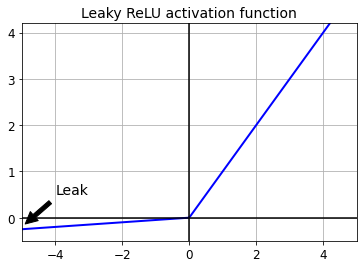

In [7]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [8]:
#LeakyReLU를 사용해 패션MNIST에서 신경망 훈련
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [10]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.7955 - accuracy: 0.7361 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7896
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5832 - accuracy: 0.8074 - val_loss: 0.5582 - val_accuracy: 0.8202
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5553 - accuracy: 0.8156 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5338 - accuracy: 0.8225 - val_loss: 0.5157 - val_accuracy:

In [11]:
#PReLU 테스트하기
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [12]:

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7630
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6966 - accuracy: 0.7694 - val_loss: 0.6565 - val_accuracy: 0.7880
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6003 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5917 - accuracy: 0.8057 - val_loss: 0.5656 - val_accuracy: 0.8178
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5618 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5390 - accuracy: 0.8205 - val_loss: 0.5196 - val_accuracy:

* ELU(Exponential Linear Unit) :  2105년 B.Xu et al.의 논문에서 제안된 활성화 함수
$$
\text{ELU}_{\alpha} = \begin{cases} \alpha \left( \exp{(x)} - 1 \right) &amp; \text{if }x &lt;0 \\ x &amp; \text{if } x \ge 0 \end{cases}
$$
<img src = "images/11_images/elu.PNG">
 - z < 0일 때 음숫값이 들어오므로 활성화 함수의 평균 출력이 0에 더 가까워진다. 그렇기 때문에 편향 이동이 감소하여 그래디언트 소실 문제를 줄여준다. 하이퍼파라미터 $\alpha$는 z가 큰 음숫값일 때 ELU가 수렴할 값을 정의한다. 보통 1로 설정
 - z < 0이어도 그레이디언트가 0이 아니므로 죽은 뉴런을 만들지 않는다.
 - $\alpha$ = 1 이면 이 함수는 z=0에서 급격히 변동하지 않으므로 z=0을 포함해 모든 구간에서 매끄러워 경사하강법의 속도를 높여준다.
 - 단점은 ReLU나 그 변종들보다 계산이 느리다.

In [13]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

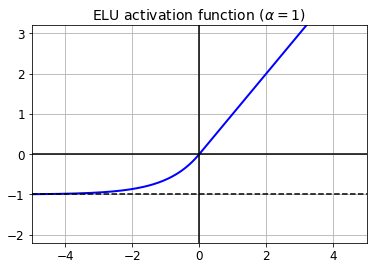

In [14]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [15]:
#텐서플로우에서 ELU적용하기
keras.layers.Dense(10, activation="elu")

* SELU(Scaled ELU) : 권터 클람바우어등의 2017년 논문에서 소개됨
* 스케일이 조정된 ELU 활성화 함수의 변종
* 완전 연결 층만 쌓아서 신경망을 만들고 모든 은닉층이 SELU 활성화 함수를 사용한다면 네트워크가 자기 정규화된다는것을 보였다.
* 훈련하는 동안 각 층의 출력이 평균 0과 표준편차 1을 유지하는 경향이 있다. 이는 그레이디언트 소실과 폭주 문제를 막아준다.
* 자기 정규화가 일어나기 위한 조건
 - 입력 특성이 반드시 표준화되어야 한다.
 - 모든 은닉층의 가중치는 르쿤 정규분포 초기화로 초기화되어야 한다. (케라스의 kernel_initializer="lecun_normal")
 - 네트워크는 일렬로 쌓은 층으로 구성되어야 한다. 순환 신경망과 같은 순차적이지 않은 구조에 SELU를 사용하면 자기 정규화되는 것이 보장되지 않는다

* TLDR : 어떠한 활성화 함수를 써야할까?

 - 일반적으로 ELU → LeakyReLU → ReLU → tanh → sigmoid 순으로 사용한다고 한다. cs231n 강의에서는 ReLU를 먼저 쓰고 , 그다음으로 LeakyReLU나 ELU 같은 ReLU Family를 쓰며, sigmoid는 사용하지 말라고 하고 있다.

In [16]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화합니다
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) *\
(2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*\
 erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [17]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

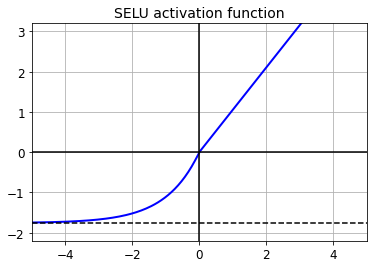

In [18]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [19]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # 표준화된 입력
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [20]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

In [21]:
#100개의 은닉층과 SELU 활성화 함수를 사용한 패션 MNIST를 위한 신경망
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [22]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [23]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [24]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 13s 8ms/step - loss: 1.4046 - accuracy: 0.4432 - val_loss: 1.2709 - val_accuracy: 0.5112
Epoch 2/5
1719/1719 [==============================] - 13s 7ms/step - loss: 1.0241 - accuracy: 0.6125 - val_loss: 0.7522 - val_accuracy: 0.7306
Epoch 3/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.7704 - accuracy: 0.7159 - val_loss: 0.7005 - val_accuracy: 0.7556
Epoch 4/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.6726 - accuracy: 0.7521 - val_loss: 0.8123 - val_accuracy: 0.7006
Epoch 5/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.6527 - accuracy: 0.7598 - val_loss: 0.7812 - val_accuracy: 0.7142


In [25]:
#그렇다면 대신 ReLU사용
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [26]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))
#그레이디언트 폭주나 소실 문제 발생

Epoch 1/5
1719/1719 [==============================] - 13s 8ms/step - loss: 1.9524 - accuracy: 0.2392 - val_loss: 1.3482 - val_accuracy: 0.4348
Epoch 2/5
1719/1719 [==============================] - 13s 7ms/step - loss: 1.1782 - accuracy: 0.5202 - val_loss: 0.9212 - val_accuracy: 0.6268
Epoch 3/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.9816 - accuracy: 0.6059 - val_loss: 0.8041 - val_accuracy: 0.6794
Epoch 4/5
1719/1719 [==============================] - 13s 8ms/step - loss: 0.7844 - accuracy: 0.6816 - val_loss: 0.7846 - val_accuracy: 0.6970
Epoch 5/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.8562 - accuracy: 0.6369 - val_loss: 0.7870 - val_accuracy: 0.7008


## 11.1.3 배치 정규화

* ELU와 함께 He 초기화를 사용하면 훈련 초기 단계에서 그레이디언트 소실이나 폭주 문제를 크게 감소시킬 수 있지만, 훈련하는 동안 다시 발생할 가능성이 있다.
* 2015년 Sergety Ioffe와 Christian Szegedy는 'Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift'라는 논문에서 배치 정규화(BN, Batch Normalization)를 제안했다.
* 배치 정규화는 각 층의 활성화 함수의 출력값 분포가 골고루 분포되도록 강제하는 방법으로, 각 층에서의 활성화 함수 출력값이 정규분포(Normal distribution)를 이루도록 하는 방법
 1. 각 충에서 활성화 함수를 통과하기 전이나 후에 모델에 연산을 하나 추가한다.
 2. 이 연산은 단순하게 입력을 원점에 맞추고 정규화한 다음, 각 층에서 두개의 새로운 파라미터로 결과값의 스케일을 조정하고 이동시킨다.
 3. 하나는 스케일 조정에, 다른 하나는 이동에 사용
* 학습하는 동안 이전 레이어에서의 가중치 매개변수가 변함에 따라 활성화 함수 출력값의 분포가 변화하는 내부 공변량 변화(Internal Covariate Shift) 문제를 줄이는 방법이 바로 배치 정규화 기법
* 배치 정규화는 미니배치(mini-batch)의 데이터에서 각 특성(feature)별 평균(mean)과 분산(variance)을 구한 뒤 정규화(normalize)해준다.
<img src = "images/11_images/bn.png" >

* 입력 데이터를 원점에 맞추고 정규화하려면 알고리즘은 평균과 표준편차를 추정해야 한다. 이를 위해 현재 미니배치에서 입력의 평균과 표준편차를 평가해야한다.
* 전체 알고리즘

 - Input : 미니배치 $B = \{ x_1, x_2, \dots, x_m \}$ 개의 입력 데이터, 학습 될 파라미터인 $\gamma, \beta$
 - Output : $\{ y_i = \text{BN}_{\gamma, \beta}(x_i) \}$
 

$$
\begin{eqnarray*} \mu _{ B } \leftarrow \frac { 1 }{ m } \sum _{ i=1 }^{ m }{ x_{ i } }  \text{// mini-batch mean}  \\ \sigma _{ B }^{ 2 }  \leftarrow   \frac { 1 }{ m } \sum _{ i=1 }^{ m }{ \left( x_{ i }-\mu _{ B } \right) ^{ 2 } }  \text{// mini-batch variance}  \\ \hat { x } _{ i }  \leftarrow   \frac { x_{ i }-\mu _{ B } }{ \sqrt { \sigma _{ B }^{ 2 }+\varepsilon }}  \text{// normalize} \\ y_{i}  \leftarrow  \gamma \hat{x}_{i} + \beta \equiv \text{BN}_{\gamma, \beta}(x_i) \text{// scale and shift} \end{eqnarray*}
$$

   - $\mu_B$ : 미니배치 $B$에 대한 평균
   - $\sigma_B$ : 미니배치 $B$에 대한 표준편차
   - $m$ : 미니배치 데이터 개수
   - $\hat{x}_i$ : 평균이 0, 분산이 1로 정규화된 입력 데이터
   - $\gamma$ : 정규화된 데이터에 대한 스케일(scale) 조정 파라미터
   - $\beta$ : 정규화된 데이터에 대한 이동(shift) 조정 파라미터
   - $\varepsilon$ : 분모가 0이 되는 것을 막기 위한 작은 숫자 ($10^{-5}$)
   - $y_i$ : $\text{BN}$ 연산의 출력 결과

* 훈련하는 동안 배치 정규화는 입력을 정규화한 다음 스케일을 조정하고 이동시킨다.
* 테스트 시에는 샘플의 배치가 아니라 샘플 하나에 대한 예측을 만들어야 한다. 이 경우 입력의 평균과 표준편차를 계산할 방법이 없다. 샘플의 배치를 사용한다 하더라도 매우 작거나 독립 동일 분포(Independent Identically Distributed, IID) 조건을 만족하지 못할 수도 있다.
* 그래서 한가지 방법은 훈련이 끝난 후 전체 훈련 세트를 신경망에 통과시켜 배치 정규화층의 각 입력에 대한 평균과 표준편차를 계산하는 것이다.
* 그러나 대부분 배치 정규화 구현은 층의 입력 평균과 표준편차의 이동 평균을 사용해 훈련하는 동안 최종 통계를 추정한다.(케라스의 BatchNormalization)
* 즉 배치 정규화 층마다 네 개의 파라미터 벡터가 학습된다.
 - $\gamma$(출력 스케일 벡터)와 $\beta$(출력 이동 벡터)는 일반적인 역전파를 통해 학습된다.
 - $\lambda$(최종 입력 평균 벡터)와 $\omega$(최종 입력 표준 편차 벡터)는 지수 이동 평균을 사용하여 추정
 - $\lambda$와 $\omega$는 훈련하는 동안 추정되지만 훈련이 끝난 후에 사용된다.
 
* 배치정규화의 장점
 - 논문에서 실험했던 모든 심층 신경망의 성능이 크게 향상 시켰다.
 - 그레이디언트 소실 문제가 크게 감소하여 수렴성을 가진 활성화 함수(하이퍼볼릭 탄젠트, 로지스틱)를 사용할 수 있다.
 - 가중치 초기화에 네트워크가 훨씬 덜 민감해진다.
 - 큰 학습률을 사용하여 학습 과정의 속도를 크게 높일 수 있다.
 - 오버피팅을 억제한다. BN이 마치 Regularization 역할을 하기 때문에 드롭아웃(Dropout)과 같은 규제기법에 대한 필요성이 감소한다. 하지만, BN로 인한 규제는 효과가 크지 않기 때문에 드롭아웃을 함께 사용하는 것이 좋다.

* 케라스로 배치 정규화 구현하기
 - 은닉층의 활성화 함수 전이나 후에 BatchNormalization층을 추가하면 된다.
 - 모델의 첫 번째 층으로 배치 정규화 층을 추가할 수도 있다.


In [27]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [28]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_212 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_213 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_214 (Dense)            (None, 10)               

In [29]:
#첫 번째 배치 정규화 층의 파라미터 / 두개는 역전파 훈련, 나머지 두개는 훈련 X
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [30]:
#이동 평균을 업데이트
bn1.updates

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


[]

In [31]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8661 - accuracy: 0.7117 - val_loss: 0.5675 - val_accuracy: 0.8076
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5734 - accuracy: 0.8016 - val_loss: 0.4864 - val_accuracy: 0.8376
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5143 - accuracy: 0.8224 - val_loss: 0.4480 - val_accuracy: 0.8458
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4763 - accuracy: 0.8349 - val_loss: 0.4259 - val_accuracy: 0.8554
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4517 - accuracy: 0.8429 - val_loss: 0.4104 - val_accuracy: 0.8626
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4356 - accuracy: 0.8473 - val_loss: 0.3985 - val_accuracy: 0.8652
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4217 - accuracy: 0.8513 - val_loss: 0.3886 - val_accuracy:

In [32]:
# 활성화 함수전에 BN을 적용해도 잘 동작합니다.
#또한 BatchNormalization 층 이전의 층은 편향을 위한 항이 필요 없습니다.
#BatchNormalization 층이 이를 무효화하기 때문입니다. 
#따라서 필요 없는 파라미터이므로 use_bias=False를 지정하여 층을 만들 수 있습니다:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 1.0569 - accuracy: 0.6798 - val_loss: 0.6812 - val_accuracy: 0.7876
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6827 - accuracy: 0.7813 - val_loss: 0.5585 - val_accuracy: 0.8230
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5990 - accuracy: 0.8015 - val_loss: 0.5022 - val_accuracy: 0.8360
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5466 - accuracy: 0.8161 - val_loss: 0.4672 - val_accuracy: 0.8446
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5139 - accuracy: 0.8249 - val_loss: 0.4439 - val_accuracy: 0.8530
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4915 - accuracy: 0.8308 - val_loss: 0.4264 - val_accuracy: 0.8594
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4738 - accuracy: 0.8376 - val_loss: 0.4135 - val_accuracy:

* BatchNormalization 클래스는 조정할 하이퍼파라미터가 적다. 보통 기본값이 잘 동작하지만 momentum 매개변수를 변경해야 할 수 있다. 지수 이동 평균을 업데이트할 때 이 하이퍼파라미터를 사용
* 새로운 값 v(현재 배치에서 계산한 새로운 입력 평균 벡터나 표준편차 벡터)가 주어지면 다음 식을 사용해 평균 $\hat{v}$를 업데이트
$$ \hat{v} \leftarrow  \hat{v} * momentum + v  *  (1 - momentum) $$
 - 적절한 모멘텀 값은 일반적으로 1에 가깝다.
 
* 중요한 다른 하이퍼파라미터는 axis
* 정규화할 축을 결정, 기본값은 -1
* 입력 배치가 2D면 각 입력 특성이 배치에 있는 모든 샘플에 대해 계산한 평균과 표준편차를 기반으로 정규화

## 11.1.4 그레이디언트 클리핑

* 그레이디언트 클리핑(Gradient Clipping) : 역전파될 때 일정 임곗값을 넘어서지 못하게 그레이디언트를 잘라내어 폭주 문제를 완화하는 방법


In [34]:
#캐라스에서 옵티마이저를 만들 때 clipvalue와 clipnorm 매개변수를 지정
optimizer = keras.optimizers.SGD(clipvalue = 1.0)
model.compile(loss = "mse", optimizer = optimizer)

* 이 옵티마이저는 그레이디언트 벡터의 모든 원소를 -1.0 과 1.0 사이로 클리핑
 - 이 기능은 그레이디언트 벡터의 방향을 바꿀 수 있다.
* 그레이디언트 클리핑이 그레이디언트 벡터의 방향을 바꾸지 못하게 하려면 clipvalue 대신 clipnorm을 지정하여 노름으로 클리핑

# 11.2 사전훈련된 층 재사용하기

* 전이 학습(Transfer Learning) : 해결하려는 것과 비슷한 유형의 문제를 처리한 신경망이 이미 있는지 찾아본 다음 그 신경망의 하위층을 재사용하는 방법
* 훈련 속도를 크게 높일 뿐만 아니라 필요한 훈련 데이터도 크게 줄여준다.
<img src = "images/11_images/pretrained.png">

 - 원래 문제에서 사용한 것과 크기가 다른 이미지를 입력으로 사용한다면 원본 모델에 맞는 크기로 변경하는 전처리 단계를 추가
 - 일반적으로 전이학습은 저수준 특성이 비슷한 입력에서 잘 작동
 - 작업이 비슷할수록 (낮은 층부터) 더 많은 층을 재사용, 아주 비슷한 작업이라면 모든 은닉층을 유지하고 출력층만 교체

 1. 재사용하는 층을 모두 동결(경사 하강법으로 가중치가 바뀌지 않도록 훈련되지 않는 가중치로 만든다)
 2. 모델을 훈련하고 성능을 평가
 3. 맨 위에 있는 한두개의 은닉층의 동결을 해제하고 역전파를 통해 가중치를 조정하여 성능이 향상되는지 확인
 - 재사용 층의 동결을 해제할 때는 학습률을 줄이는 것이 좋다.

## 11.2.1 케라스를 사용한 전이 학습

* 패션 MNIST 훈련 세트를 두 개로 나누기
 - X_train_A: 샌달과 셔츠(클래스 5와 6)을 제외한 모든 이미지
 - X_train_B: 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트

* A세트(8개의 클래스를 가진 분류 문제)에서 모델을 훈련하고 이를 재사용하여 B세트(이진 분류)를 해결

In [35]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [36]:
print(X_train_A.shape)
print(X_train_B.shape)

(43986, 28, 28)
(200, 28, 28)


In [37]:
#model_A 학습
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [38]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.5976 - accuracy: 0.8062 - val_loss: 0.3904 - val_accuracy: 0.8637
Epoch 2/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.3630 - accuracy: 0.8738 - val_loss: 0.3278 - val_accuracy: 0.8844
Epoch 3/20
1375/1375 [==============================] - 2s 2ms/step - loss: 0.3231 - accuracy: 0.8872 - val_loss: 0.2977 - val_accuracy: 0.8934
Epoch 4/20
1375/1375 [==============================] - 2s 2ms/step - loss: 0.3025 - accuracy: 0.8959 - val_loss: 0.2840 - val_accuracy: 0.9016
Epoch 5/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2886 - accuracy: 0.8996 - val_loss: 0.2733 - val_accuracy: 0.9038
Epoch 6/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2783 - accuracy: 0.9043 - val_loss: 0.2657 - val_accuracy: 0.9071
Epoch 7/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2697 - accuracy: 0.9083 - val_loss: 0.2628 - val_accuracy:

In [39]:
#모델 저장
model_A.save("images/model/my_model_A.h5")

In [40]:
#model_B 학습
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [41]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 23ms/step - loss: 0.5374 - accuracy: 0.7150 - val_loss: 0.4657 - val_accuracy: 0.7657
Epoch 2/20
7/7 [==============================] - 0s 8ms/step - loss: 0.4636 - accuracy: 0.7600 - val_loss: 0.4030 - val_accuracy: 0.8570
Epoch 3/20
7/7 [==============================] - 0s 8ms/step - loss: 0.3996 - accuracy: 0.8400 - val_loss: 0.3568 - val_accuracy: 0.9138
Epoch 4/20
7/7 [==============================] - 0s 7ms/step - loss: 0.3529 - accuracy: 0.8850 - val_loss: 0.3211 - val_accuracy: 0.9320
Epoch 5/20
7/7 [==============================] - 0s 8ms/step - loss: 0.3162 - accuracy: 0.9100 - val_loss: 0.2905 - val_accuracy: 0.9554
Epoch 6/20
7/7 [==============================] - 0s 8ms/step - loss: 0.2838 - accuracy: 0.9450 - val_loss: 0.2639 - val_accuracy: 0.9675
Epoch 7/20
7/7 [==============================] - 0s 8ms/step - loss: 0.2571 - accuracy: 0.9550 - val_loss: 0.2442 - val_accuracy: 0.9716
Epoch 8/20
7/7 [=================

In [42]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_215 (Dense)            (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_216 (Dense)            (None, 100)               30000     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)              

In [43]:
#model_A를 로드하고, 이 모델의 층을 기반으로 model_B_on_A를 생성(출력층 제외 모든 층 재사용)
model_A = keras.models.load_model("images/model/my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation = "sigmoid"))

In [44]:
#층울 공유하는 과정에서 원본에 영향을 주지 않기 위해 clone 파일 만들기
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [45]:
#처음 몇 번의 에포크 동안 재사용된 층을 동결하고 새로운 층에 적절한 가중치를 학습할 시간 제공
#모든 층의 trainable 속성을 False로 지정하고 모델을 컴파일
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [46]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 57ms/step - loss: 0.8379 - accuracy: 0.6400 - val_loss: 0.8100 - val_accuracy: 0.6562
Epoch 2/4
7/7 [==============================] - 0s 7ms/step - loss: 0.7870 - accuracy: 0.6550 - val_loss: 0.7696 - val_accuracy: 0.6673
Epoch 3/4
7/7 [==============================] - 0s 8ms/step - loss: 0.7455 - accuracy: 0.6700 - val_loss: 0.7300 - val_accuracy: 0.6785
Epoch 4/4
7/7 [==============================] - 0s 8ms/step - loss: 0.7050 - accuracy: 0.6900 - val_loss: 0.6896 - val_accuracy: 0.6897
Epoch 1/16
7/7 [==============================] - 0s 23ms/step - loss: 0.5468 - accuracy: 0.7500 - val_loss: 0.4032 - val_accuracy: 0.8114
Epoch 2/16
7/7 [==============================] - 0s 8ms/step - loss: 0.3348 - accuracy: 0.8850 - val_loss: 0.3129 - val_accuracy: 0.8966
Epoch 3/16
7/7 [==============================] - 0s 8ms/step - loss: 0.2588 - accuracy: 0.9650 - val_loss: 0.2573 - val_accuracy: 0.9331
Epoch 4/16
7/7 [====================

In [47]:
#최종 점수
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.1197 - accuracy: 0.9880


[0.11966752260923386, 0.9879999756813049]

In [48]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.0808 - accuracy: 0.9875


[0.08082611113786697, 0.987500011920929]

## 11.2.2 비지도 사전훈련

* 레이블된 훈련 데이터가 많지 않은 복잡한 문제가 있는데, 아쉽게도 비슷한 작업에 대해 훈련된 모델을 찾을 수 없다고 가정했을 때 사용할 수 있는 방법은 비지도 사전훈련(Unsupervised Pretraining)이다.
* 딥러닝 초기에는 층이 많은 모델을 훈련하는 것이 어려웠기 때문에 탐욕적 층 단위 사전훈련(Greedy layer-wise pretraining)이라는 기법을 사용
 - 하나의 층을 가진 비지도 학습 모델을 훈련(일반적으로 RBM)
 - 그 다음 이 층을 동결하고 그 위에 다른 층을 추가한 다음 모델을 다시 훈련
 - 이를 반복
* 오늘날에는 일반적으로 한 번에 전체 비지도 학습 모델을 훈련하고(바로 세번째 단계를 시작), RBM 대신 오토인코더나 GAN사용

# 11.3 고속 옵티마이저 

* 훈련 속도를 높이는 네 가지 방법
 - 연결 가중치에 좋은 초기화 전략 적용하기
 - 좋은 활성화 함수 사용하기
 - 배치 정규화 사용하기
 - 사전훈련된 네트워크의 일부 재사용하기
 
* 훈련 속도를 크게 높일 수 있는 또 다른 방법으로 표준적인 경사 하강법 옵티마이저 대신 더 빠른 옵티마이저를 사용할 수 있다.

##  11.3.1 모멘텀 최적화

* 모멘텀 최적화의 간단한 원리는 처음에는 느리게 출발하지만 종단속도에 도달할 때 까지 빠르게 가속되는 원리이다.
* 이전 그레이디언트가 얼마였는지를 고려하여, 매 반복에서 현재 그레이디언트를 (학습률을 곱한 후) 모멘텀 벡터(Momentum Vector) m에 더하고 이 값을 빼는 방식으로 가중치를 갱신한다.
* 즉, 그레이디언트를 속도가 아니라 가속도로 사용한다.
* 일종의 마찰저항을 표현하고 모멘텀이 너무 커지는 것을 막기 위해 이 알고리즘에 모멘텀(Momentum)이라는 새로운 하이퍼 파라미터 $\beta$가 등장
 - 모멘텀은 0~1 사이로 설정되며, 일반적인 값은 0.9이다.
* 모멘텀 알고리즘
 - 1. $m \leftarrow \beta m - \eta \nabla_{\theta}J(\theta)$ 
 - 2. $\theta \leftarrow \theta + m$
* 모멘텀 최적화는 경사 하강법보다 평편한 지역을 탈출하게 도와준다.
* 모멘텀 최적화는 지역 최적점을 건너뛰도록 하는데도 도움이 된다.

In [49]:
# 케라스에서 모멘텀 최적화 구현
optimizer = keras.optimizers.SGD(lr = 0.001, momentum = 0.9)

## 11.3.2 네스테로프 가속 경사

* 네스테로프 가속 경사(Nesterov Accelerated Gradient, NAG)는 현재 위치가 $\theta$가 아니라 모멘텀의 방향으로 조금 앞선 $\theta + \beta m$에서 비용 함수의 그레이디언트를 계산하는 것
* 네스테로프 가속 경사 알고리즘
 - 1. $m \leftarrow \beta m - \eta \nabla_{\theta}J(\theta + \beta m)$ 
 - 2. $\theta \leftarrow \theta + m$
 
* 원래 위치에서의 그레이디언트를 사용하는 것보다 그 방향으로 조금 더 나아가서 측정한 그레이디언트를 사용하는 것이 약간 더 정확할 것이다.
* 시간이 조금 지나면 이 작은 개선이 쌓여서 NAG가 기본 모멘텀 최적화보다 확연히 빨라지게 된다.
* NAG가 일반적으로 기본 모멘텀 최적화보다 훈련 속도가 빠르다.

In [50]:
#네스테로프 가속 경사
optimizer = keras.optimizers.SGD(lr = 0.001, momentum=0.9, nesterov = True)

## 11.3.3 AdaGrad

* 가장 가파른 차원을 따라 그레이디언트 벡터의 스케일을 감소시켜 이 문제를 해결
* AdaGrad 알고리즘
 - 1. $s \leftarrow s + \nabla_{\theta}J(\theta)$ ⓧ $\nabla_{\theta}J(\theta)$
 - 2. $\theta \leftarrow \theta - \eta \nabla_{\theta}J(\theta)$ / $\sqrt{s + \epsilon}$
 - ⓧ : 원소별 곱셈, / : 원소별 나눗셈
   - 첫번쨰 단계는 파라미터 $\theta$ 에 대한 비용 함수의 편미분을 제곱하여 누적
   - 두번째 단계는 경사 하강법과 거의 같지만 차이점은 그레이디언트 벡터를 $\sqrt{s + \epsilon}$ 으로 나누어 스케일을 조정
* 이 알고리즘은 학습률은 감소시키지만 경사가 완만한 차원보다 가파른 차원에 대해 더 빠르게 감소된다. 이를 적응적 학습률(Adaptive Learning Rate)이라고 부르며, 전역 최적점 방향으로 더 곧장 가도록 갱신되는 데 도움이 된다.
* 학습률 하이퍼파라미터를 덜 튜닝해도 되는 장점이 있다.
* AdaGrad는 간단한 2차방정식 문제에 대해서는 잘 작동되지만, 신경망을 훈련할 때 너무 일찍 멈추는 경우가 종종 있다. 그래서 심층 신경망에는 사용하지 말아야 한다.

In [51]:
#AdaGrad
optimizer = keras.optimizers.Adagrad(lr=0.001)

## 11.3.4 RMSProp 

* AdaGrad는 너무 빨리 느려져서 전역 최적점에 수렴하지 못하는 위험이 있어서, RMSProp 알고리즘은 가장 최근 반복에서 비롯된 그레이디언트만 누적함으로써 이 문제를 해결
* RMSProp 알고리즘
 - 1. $s \leftarrow \beta s + (1 - \beta) \nabla_{\theta}J(\theta)$ ⓧ $\nabla_{\theta}J(\theta)$
 - 2. $\theta \leftarrow \theta - \eta \nabla_{\theta}J(\theta)$ / $\sqrt{s + \epsilon}$
 - ⓧ : 원소별 곱셈, / : 원소별 나눗셈
* 첫 번째 단계에서 지수 감소를 사용, 보통 감쇠율 $\beta$ 는 0.9로 설정

In [52]:
#RMSProp 옵티마이저
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

## 11.3.5 Adam과 Nadam 최적화

* 적응적 모멘트 추정(Adaptive Moment Estimation, Adam) : 모멘텀 최적화와 RMSProp의 아이디어를 합친 것으로, 모멘텀 최적화처럼 지난 그레이디언트의 지수 감소 평균을 따르고 RMSProp처럼 지난 그레이디언트 제곱의 지수 감소된 평균을 따른다.
* Adam 알고리즘
 - 1.  $m \leftarrow \beta _{1}m -(1 - \beta_{1}) \nabla_{\theta}J(\theta)$
 - 2.  $s \leftarrow \beta _{2}s + (1 - \beta_{2}) \nabla_{\theta}J(\theta)$ ⓧ $\nabla_{\theta}J(\theta)$
 - 3.  $\hat{m} \leftarrow \frac{m}{1-\beta_{1}^t}$
 - 4.  $\hat{s} \leftarrow \frac{s}{1-\beta_{2}^t}$
 - 5.  $\theta \leftarrow \theta + \eta \hat{m}$ / $\sqrt{\hat{s} + \epsilon}$
 - ⓧ : 원소별 곱셈, / : 원소별 나눗셈
* 모멘텀 감쇠 하이퍼파라미터 $\beta_{1}$은 보통 0.9로 초기화하고 스케일 감쇠 하이퍼파라미터 $\beta_{2}$는 0.999로 초기화하는 경우가 많다.
* Adam이 적응적 학습률 알고리즘이기 떄문에 학습률 하이퍼파라미터를 튜닝할 필요가 적다.
* 기본값 $\eta$ = 0.001을 일반적으로 사용하므로 경사 하강법보다 Adam이 사용하기 더 쉽다.

In [53]:
#Adam 옵티마이저
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

#### Adam의 두가지 변종

* AdaMax
 - Adam은 시간에 다라 감쇠된 그레이디언트의 노름_1(제곱합의 제곱근)으로 파라미터 업데이트의 스케일을 낮춘다.
 - AdaMax는 노름$_1$(제곱근의 제곱근)을 노름$_∞$으로 바꾼다.
 - 구체적으로 Adam 알고리즘의 2단계를 $s \leftarrow max(\beta_{2}s, \nabla_{\theta}J(\theta))$ 로 바꾸고 4단계를 삭제한다.
 - 5단계에서 s에 비례하여 그레이디언트 업데이트의 스케일을 낮춘다. 시간에 다라 감쇠된 그레이디언트의 최댓값이다.
 - 실전에서 AdaMax가 Adam보다 더 안정적이다. Adma이 성능이 일반적으로 더 낫긴하지만, Adma이 잘 동작하지 않는다면 시도할 수 있는 옵티마이저 중 하나.

* Nadam
 - Adam 옵티마이저에 네스테로프 기법을 더한 것으로 따라서 종종 Adam보다 조금 더 빠르게 수렴한다.
 

In [54]:
#AdaMax 옵티마이저
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)
#Nadam 옵티마이저
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

## 11.3.6 학습률 스케줄링

* 학습 스케줄(Learning Schedule) : 훈련하는 동안 학습률을 감소시키는 전략

* 거듭제곱 기반 스케줄링(Power Scheduling)
 - 학습률을 반복 횟수 t에 대한 함수 $\eta (t) = \eta_{0} / (1 + t/s)^c$로 지정
 - 거듭제곱 수 c(일반적으로 1로 지정), 스텝 횟수 s는 하이퍼 파라미터
 - 학습률은 각 스텝마다 감소된다. s번 스텝을 n번 진행한 뒤에 학습률은 $\eta_{0} / n$로 줄어든다.
 - 처음에는 빠르게 감소하다가 점점 더 느리게 감소된다.

In [55]:
#거듭제곱 기반 스케줄링
#lr = lr0 / (1 + steps / s)**c
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [56]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4861 - accuracy: 0.8292 - val_loss: 0.4079 - val_accuracy: 0.8566
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3788 - accuracy: 0.8660 - val_loss: 0.3750 - val_accuracy: 0.8698
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3457 - accuracy: 0.8773 - val_loss: 0.3718 - val_accuracy: 0.8728
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3242 - accuracy: 0.8844 - val_loss: 0.3482 - val_accuracy: 0.8798
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3089 - accuracy: 0.8909 - val_loss: 0.3402 - val_accuracy: 0.8808
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2949 - accuracy: 0.8960 - val_loss: 0.3390 - val_accuracy: 0.8830
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2850 - accuracy: 0.8994 - val_loss: 0.3359 - val_accuracy:

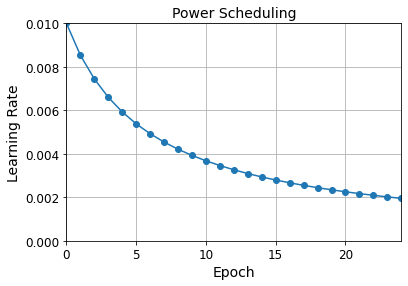

In [57]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

* 지수 기반 스케줄링(Exponential Scheduling)
 - 학습률을 $\eta (t) = \eta_{0} 0.1^{t/s}$ 로 설
 - 학습률이 s 스텝마다 10배씩 점차 줄어든다.

In [58]:
#지수 기반 스케줄링
#lr = lr0 * 0.1**(epoch / s)
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [59]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8188 - accuracy: 0.7642 - val_loss: 0.8085 - val_accuracy: 0.7562
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6736 - accuracy: 0.7965 - val_loss: 0.7482 - val_accuracy: 0.8172
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6042 - accuracy: 0.8162 - val_loss: 0.7882 - val_accuracy: 0.7518
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5642 - accuracy: 0.8324 - val_loss: 0.6052 - val_accuracy: 0.8086
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4865 - accuracy: 0.8475 - val_loss: 0.5066 - val_accuracy: 0.8634
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4501 - accuracy: 0.8585 - val_loss: 0.4634 - val_accuracy: 0.8568
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4112 - accuracy: 0.8689 - val_loss: 0.5464 - val_accuracy:

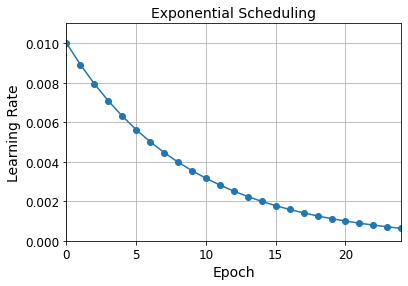

In [60]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [61]:
#이 스케줄 함수는 두 번째 매개변수로 현재 학습률을 받을 수 있다.
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

In [62]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # 노트: 에포크마다 `batch` 매개변수가 재설정됩니다
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # 20 에포크 동안 스텝 횟수 (배치 크기 = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8099 - accuracy: 0.7645 - val_loss: 0.8965 - val_accuracy: 0.7608
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6510 - accuracy: 0.8032 - val_loss: 0.6817 - val_accuracy: 0.8250
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5822 - accuracy: 0.8198 - val_loss: 0.7133 - val_accuracy: 0.8008
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5435 - accuracy: 0.8317 - val_loss: 0.5062 - val_accuracy: 0.8454
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4790 - accuracy: 0.8463 - val_loss: 0.4562 - val_accuracy: 0.8602
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4526 - accuracy: 0.8564 - val_loss: 0.4924 - val_accuracy: 0.8512
Epoch 7/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4123 - accuracy: 0.8666 - val_loss: 0.4749 - val_accuracy:

In [63]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

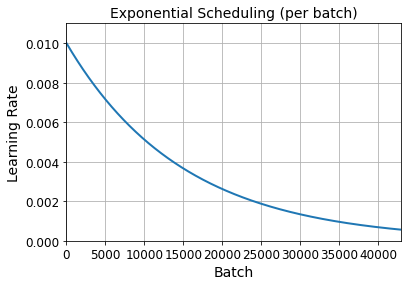

In [64]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

* 구간별 고정 스케줄링(Piecewise Constant Scheduling)
 - 일정 횟수의 에포크 동안 일정한 학습률을 사용하고 그다음 또 다른 횟수의 에포크 동안 작은 학습률을 사용하는 식
 - 이 방법이 잘 동작할 수 있지만 적절한 학습률과 에포크 횟수의 조합을 찾으려면 이리저러 바꿔봐야한다.


In [65]:
#구간별 고정 스케줄링
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [66]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [67]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8574 - accuracy: 0.7532 - val_loss: 0.9095 - val_accuracy: 0.7524
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.9848 - accuracy: 0.7051 - val_loss: 0.8489 - val_accuracy: 0.7278
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 1.0438 - accuracy: 0.6425 - val_loss: 1.1359 - val_accuracy: 0.5658
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 1.0515 - accuracy: 0.6097 - val_loss: 1.1306 - val_accuracy: 0.5912
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 1.0792 - accuracy: 0.6142 - val_loss: 0.9930 - val_accuracy: 0.6216
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8237 - accuracy: 0.6575 - val_loss: 0.8726 - val_accuracy: 0.6652
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7728 - accuracy: 0.6723 - val_loss: 0.8414 - val_accuracy:

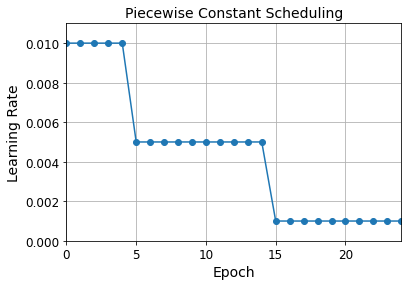

In [68]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

* 성능 기반 스케줄링(Performance Scheduling)
 - 매 N 스텝마다 검증 오차를 측정하고 오차가 줄어들지 않으면 $\lambda$배 만큼 학습률을 감소시킨다.

In [69]:
#성능 기반 스케줄링
tf.random.set_seed(42)
np.random.seed(42)

In [70]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5883 - accuracy: 0.8074 - val_loss: 0.4960 - val_accuracy: 0.8428
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5038 - accuracy: 0.8389 - val_loss: 0.6474 - val_accuracy: 0.8220
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5079 - accuracy: 0.8419 - val_loss: 0.4609 - val_accuracy: 0.8578
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5094 - accuracy: 0.8469 - val_loss: 0.5136 - val_accuracy: 0.8462
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5175 - accuracy: 0.8500 - val_loss: 0.5288 - val_accuracy: 0.8394
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5074 - accuracy: 0.8541 - val_loss: 0.5681 - val_accuracy: 0.8556
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5289 - accuracy: 0.8546 - val_loss: 0.5782 - val_accuracy:

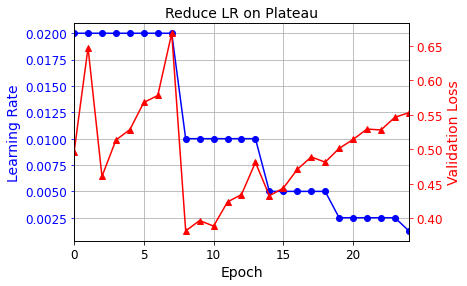

In [71]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

* 1 사이클 스케줄링(1 Cycle Scheduling)
 - 다른 방식과 대조적으로 1사이클은 훈련 절반 동안 초기 학습률 $\eta_{0}$을 선형적으로 $\eta_{1}$까지 증가시킨다. 그 다음 나머지 절반 동안 선형적으로 학습률을 $\eta_{0}$까지 다시 줄인다.
 - 마지막 몇 번의 에포크는 학습률을 소수점 몇 째 자리까지 줄인다.
 - 최대 학습률 $\eta_{1}$은 최적의 학습률을 찾을 때와 같은 방식을 사용해 선택하고 초기 학습률 $\eta_{0}$은 대략 10배 정도 낮은 값을 선택한다
 - 모멘텀을 사용할 때는 처음에 높은 모멘텀으로 시작해서 훈련의 처음 절반 동안 낮은 모멘텀으로 줄어든다. 그 다음 다시 나머지 훈련 절반 동안 최대값으로 되돌린다. 마지막의 몇 번의 에포크는 최대값으로 진행한다.

In [72]:
#1사이클 스케줄링
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [73]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.3916


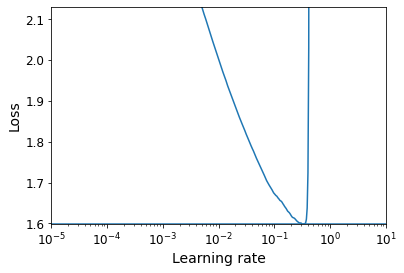

In [74]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [75]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [76]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 1s 2ms/step - loss: 0.6572 - accuracy: 0.7739 - val_loss: 0.4871 - val_accuracy: 0.8336
Epoch 2/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4581 - accuracy: 0.8396 - val_loss: 0.4274 - val_accuracy: 0.8524
Epoch 3/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4121 - accuracy: 0.8546 - val_loss: 0.4114 - val_accuracy: 0.8584
Epoch 4/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3836 - accuracy: 0.8642 - val_loss: 0.3867 - val_accuracy: 0.8686
Epoch 5/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3639 - accuracy: 0.8717 - val_loss: 0.3766 - val_accuracy: 0.8680
Epoch 6/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3456 - accuracy: 0.8774 - val_loss: 0.3742 - val_accuracy: 0.8706
Epoch 7/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3330 - accuracy: 0.8811 - val_loss: 0.3629 - val_accuracy: 0.8704
Epoch 

In [77]:
#tf.keras 스케줄러
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4894 - accuracy: 0.8274 - val_loss: 0.4092 - val_accuracy: 0.8604
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3820 - accuracy: 0.8651 - val_loss: 0.3739 - val_accuracy: 0.8692
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3487 - accuracy: 0.8767 - val_loss: 0.3731 - val_accuracy: 0.8696
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3264 - accuracy: 0.8837 - val_loss: 0.3494 - val_accuracy: 0.8802
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3104 - accuracy: 0.8897 - val_loss: 0.3430 - val_accuracy: 0.8796
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2958 - accuracy: 0.8952 - val_loss: 0.3414 - val_accuracy: 0.8810
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2854 - accuracy: 0.8989 - val_loss: 0.3354 - val_accuracy:

In [78]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

# 11.4 규제를 사용해 과대적합 피하기

## 11.4.1 $ℓ_{1} 과 ℓ_{2}$ 규제

* 신경망의 연결 가중치를 제한하기 위해 $ℓ_2$규제를 사용하거나 희소 모델을 만들기 위해 $ℓ_1$ 규제를 사용할 수 있다

In [79]:
#케라스 층의 연결 가중치에 규제 강도 0.01을 사용하여 ℓ_2 규제 적용
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

In [80]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 1.5816 - accuracy: 0.8115 - val_loss: 0.7197 - val_accuracy: 0.8302
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7210 - accuracy: 0.8276 - val_loss: 0.6862 - val_accuracy: 0.8360


In [81]:
#반복문을 피하기 위해 코드를 리팩터링
#파이썬의 functions.partial() 함수를 사용하여 기본 매개변수 값을 함수 호출을 감싸기
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 1.6630 - accuracy: 0.8122 - val_loss: 0.7201 - val_accuracy: 0.8308
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7188 - accuracy: 0.8266 - val_loss: 0.6806 - val_accuracy: 0.8402


## 11.4.2 드롭아웃

* 매 훈련 스텝에서 각 뉴런은 임시적으로 드롭아웃될 확률 p를 가진다. 즉, 이번 훈련 스텝에는 완전히 무시되지만 다음 스텝에는 활성화 될 수 있다.
* 하이퍼파라미터 p를 드롭아웃 비율(Dropout Rate)라고 하고 보통 10%~50% 사이를 지정한다.
* 드롭아웃을 통해 입력값의 작은 변화에 덜 민감해진다. 결국 더 안정적인 네트워크가 되어 일반화 성능이 좋아진다.

In [82]:
#드롭아웃 비율을 0.2를 사용한 드롭아웃 규제를 모든 Dense층 이전에 적용하는 코드
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5709 - accuracy: 0.8030 - val_loss: 0.3613 - val_accuracy: 0.8726
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4180 - accuracy: 0.8464 - val_loss: 0.3497 - val_accuracy: 0.8698


* 알파 드롭아웃
 - 드롭아웃 이후에도 자기-정규화 특성이 보장되도록 인풋의 평균과 분산을 원래값으로 유지하는 드롭아웃
 - 활성화를 무작위로 음수 포화값에 지정하여, 조정 지수 선형 유닛(Scaled Exponential Linear Units)에 대한 학습에 탁월하다.

In [83]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))


Epoch 1/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6681 - accuracy: 0.7571 - val_loss: 0.6030 - val_accuracy: 0.8398
Epoch 2/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5583 - accuracy: 0.7948 - val_loss: 0.5612 - val_accuracy: 0.8446
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5289 - accuracy: 0.8028 - val_loss: 0.4930 - val_accuracy: 0.8578
Epoch 4/20
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5055 - accuracy: 0.8123 - val_loss: 0.4695 - val_accuracy: 0.8568
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4926 - accuracy: 0.8164 - val_loss: 0.4460 - val_accuracy: 0.8550
Epoch 6/20
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4831 - accuracy: 0.8216 - val_loss: 0.4640 - val_accuracy: 0.8590
Epoch 7/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4767 - accuracy: 0.8216 - val_loss: 0.4723 - val_accuracy:

In [84]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.4406 - accuracy: 0.8665


[0.44055113196372986, 0.8665000200271606]

In [85]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 2s 1ms/step - loss: 0.3275 - accuracy: 0.8857


[0.32754650712013245, 0.8856909275054932]

In [86]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 2s 1ms/step - loss: 0.4190 - accuracy: 0.8426


## 11.4.3 몬테 카를로 드롭아웃

* 훈련된 드롭아웃 모델을 재훈련하거나 전혀 수정하지않고 성능을 크게 향상시킬 수 있는 몬테 카를로 드롭아웃(Monte Carlo Dropout, MCDropout)이라 불리는 기법 발견
* 드롭아웃으로 만득 예측을 평균하면 일반적으로 드롭아웃이 없이 예측한 하나의 결과보다 더 안정적이다.

In [87]:
#MC드롭아웃
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [88]:
#드롭아웃을 끈 패션MNIST
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [89]:
#드롭아웃을 활성화
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.21, 0.  , 0.68]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.47, 0.  , 0.02, 0.  , 0.51]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.58, 0.  , 0.42]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.44, 0.  , 0.12, 0.  , 0.45]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.41, 0.  , 0.05, 0.  , 0.54]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.18, 0.  , 0.01, 0.  , 0.8 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.26, 0.  , 0.07, 0.  , 0.66]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.1 , 0.  , 0.77]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.07, 0.  , 0.91]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.22, 0.  , 0.04, 0.  , 0.74]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0

In [90]:
#드롭아웃 예측 확률
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.13, 0.  , 0.66]],
      dtype=float32)

In [91]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.26, 0.  , 0.19, 0.  , 0.29]],
      dtype=float32)

In [92]:
y_pred = np.argmax(y_proba, axis=1)

In [93]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8638

In [94]:
#모델이 훈련하는 동안 다르게 작동하는 층을 가지고 있을 때 MC 드롭아웃 코드
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [95]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [96]:
mc_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense_262 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_263 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_264 (Dense)            (None, 10)              

In [97]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [98]:
mc_model.set_weights(model.get_weights())

In [99]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.23, 0.  , 0.15, 0.  , 0.63]],
      dtype=float32)

## 11.4.4 맥스-노름 규제

* 맥스-노름 규제(Max-Norm Regularization) : 각각의 뉴런에 대해 입력의 연결 가중치 w가 $||w||_2 ≤ r$이 되도록 제한한다.
* r은 맥스-노름 하이퍼파라미터이고 $||ㆍ||_2 는 ℓ_2$는 노름을 나타낸다.
* 전체 손실 함수에 규제 손실 항을 추가하지 않는다. 대신 일반적으로 매훈련 스텝이 끝나고 $||w||_2$를 계산하고 필요하면 w의 스케일을 조정한다.
* r을 줄이면 규제의 양이 증가하여 과대적합을 감소시키는데 도움이 된다.

In [100]:

layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [101]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4804 - accuracy: 0.8324 - val_loss: 0.3646 - val_accuracy: 0.8676
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3536 - accuracy: 0.8716 - val_loss: 0.3836 - val_accuracy: 0.8660
